In [19]:
# Import libraries used in this notebook
import os
import cv2
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset


# Set File path for Image Data
data_filepath = '../data/chest_xray'

In [13]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
# Create a Dataframe of image paths and their corresponding Label (Normal, Pnemonia)

# Only use Train dataset. Remove hash to add test/val
image_dirs = ['train'] #, 'test', 'val'] 
data = []

# Loop through Image Directories to find images
for dir in image_dirs:
    dir_path = os.path.join(data_filepath, dir)
    # Loop through NORMAL and PNEUMONIA directories, and label images accordingly
    for label_name in ["NORMAL", "PNEUMONIA"]:
        label_dir = os.path.join(dir_path, label_name)
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            # Ensure it's an image file (basic check)
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                data.append([dir, file_path, label_name])

    
# Create DataFrame
df = pd.DataFrame(data, columns=["directory", "image_path", "label"])
df

,directory,image_path,label
0,train,../data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,NORMAL
1,train,../data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,NORMAL
2,train,../data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,NORMAL
3,train,../data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,NORMAL
4,train,../data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,NORMAL
...,...,...,...
5211,train,../data/chest_xray\train\PNEUMONIA\person99_vi...,PNEUMONIA
5212,train,../data/chest_xray\train\PNEUMONIA\person9_bac...,PNEUMONIA
5213,train,../data/chest_xray\train\PNEUMONIA\person9_bac...,PNEUMONIA
5214,train,../data/chest_xray\train\PNEUMONIA\person9_bac...,PNEUMONIA


In [10]:
class XrayImageDataset(Dataset):
    def __init__(self, df_imagepaths, transform=None):
        self.df_imagepaths = df_imagepaths  # ✅ Store DataFrame
        self.transform = transform  # ✅ Store transforms
        
    def __getitem__(self, idx):
        # ✅ Correct way to get image path
        img_path = self.df_imagepaths.iloc[idx]["image_path"]       
        image = Image.open(img_path).convert("L")  # ✅ Load as grayscale

        # ✅ Correct way to get label
        label = self.df_imagepaths.iloc[idx]["label"]

        # ✅ Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label  # ✅ Returns both (optional: remove label for GAN)
        
    def __len__(self):
        return len(self.df_imagepaths)  # ✅ Correctly returns dataset size
    
xray_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel grayscale
    transforms.Resize((320, 320)),  # Resize for consistency
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for DCGAN
])



5216
Label: NORMAL


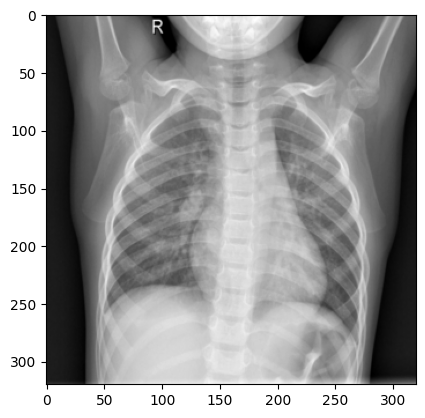

In [11]:
dataset = XrayImageDataset(df, transform=xray_transform)
print(len(dataset))  # Check total dataset size
image, label = dataset[0]  # Get the first image-label pair
plt.imshow(image.squeeze(), cmap="gray")  # Display the image
print(f"Label: {label}")


In [14]:
# Hyperparams

manualSeed = 999

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 320

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# ensures that the system trains for at least a little bit
min_epochs = 20

# If D_loss & G_loss don't improve for 10 epochs, stop training.
patience = 10

# If the change in D_loss or G_loss is less than delta, it’s considered "no improvement".
g_d_loss_delta = 0.01

In [17]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
             # state size. ``(ngf*2) x 32 x 32``
            nn.ConvTranspose2d( ngf , ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2),
            nn.ReLU(True),
             # state size. ``(ngf*2) x 64 x 64``
            nn.ConvTranspose2d( ngf//2, ngf//4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//4),
            nn.ReLU(True),
             # state size. ``(ngf*2) x 128 x 128``
            nn.ConvTranspose2d( ngf//4, ngf//8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//8),
            nn.ReLU(True),
            # state size. ``(ngf) x 256 x 256 ``
            nn.ConvTranspose2d( ngf//8, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. ``(nc) x 320 x 320``
        )

    def forward(self, input):
        return self.main(input)

In [21]:
#Discriminator

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 320 x 320``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 160 x 160``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 80 x 80``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 40 x 40``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 20 x 20``
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 10 x 10``
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 5 x 5``
            nn.Conv2d(ndf * 32, 1, 5, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply weights initialization
netG.apply(weights_init)

# Print model structure
print(netG)


# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply weights initialization
netD.apply(weights_init)

# Print model structure
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(